## Wine Quality
https://www.kaggle.com/datasets/rajyellow46/wine-quality?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors
import h5py
from scipy.io.arff import loadarff 
from utils.utils_knn import *
from sklearn.datasets import load_breast_cancer

sns.set_style('darkgrid')

SEED = 42

np.random.seed(SEED)
sns.set()

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load Data

In [3]:
data = loadarff('data/WBC_v01.arff')

df = pd.DataFrame(data[0]).drop(["id"], axis=1)
features = ["radius", "texture", "perimeter", "area" ,"smoothness", "compactness", "concavity", "concave points", "symmetry"]
df.columns = np.append(features, "label")
df.head(5)

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,label
0,8.0,6.0,4.0,3.0,5.0,9.0,3.0,1.0,1.0,"b""'yes'"""
1,8.0,8.0,9.0,6.0,6.0,3.0,10.0,10.0,1.0,"b""'yes'"""
2,5.0,10.0,10.0,10.0,10.0,2.0,10.0,10.0,10.0,"b""'yes'"""
3,6.0,10.0,7.0,7.0,6.0,4.0,8.0,10.0,2.0,"b""'yes'"""
4,10.0,5.0,8.0,10.0,3.0,10.0,5.0,1.0,3.0,"b""'yes'"""


In [4]:
Y = df["label"].values.astype("str")
Y = (Y=="'yes'").astype(int)
X = df.drop(["label"], axis=1).values


print(f"Outlier Rate: {50 / len(X) * 100}")


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Y.shape, X_scaled.shape

Outlier Rate: 11.013215859030836


((454,), (454, 9))

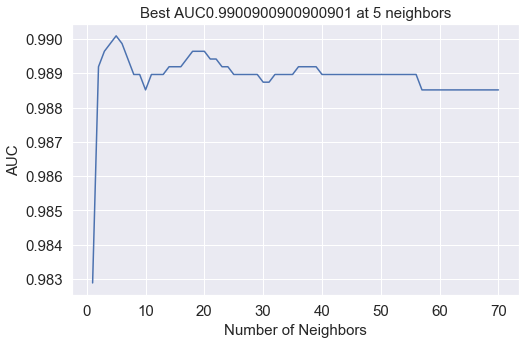

In [5]:
#find best k
aucs = gridsearch_n(X_scaled, Y, min_n=1, max_n=70, plot=True)

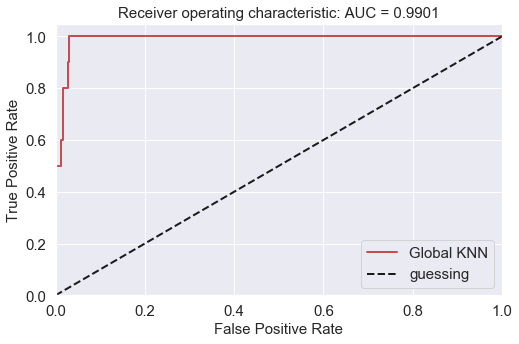

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,score,label
2,5.0,10.0,10.0,10.0,10.0,2.0,10.0,10.0,10.0,1.293189,1
1,8.0,8.0,9.0,6.0,6.0,3.0,10.0,10.0,1.0,0.831202,1
4,10.0,5.0,8.0,10.0,3.0,10.0,5.0,1.0,3.0,0.793308,1
3,6.0,10.0,7.0,7.0,6.0,4.0,8.0,10.0,2.0,0.780620,1
5,10.0,3.0,3.0,10.0,2.0,10.0,7.0,3.0,3.0,0.774917,1
13,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.654915,0
117,8.0,4.0,4.0,5.0,4.0,7.0,7.0,8.0,2.0,0.615665,0
294,5.0,1.0,2.0,10.0,4.0,5.0,2.0,1.0,1.0,0.605603,0
91,3.0,1.0,1.0,3.0,8.0,1.0,5.0,8.0,1.0,0.603375,0
253,6.0,9.0,7.0,5.0,5.0,8.0,4.0,2.0,1.0,0.591482,0


In [6]:
N_NEIGHBORS = 5
ALGORITHM = "brute"

scores, neigh = fit_predict_knn(X_scaled, N_NEIGHBORS, ALGORITHM)

scored_df = pd.DataFrame(X)
scored_df.columns = df.columns[:-1]
scored_df.index = df.index 
scored_df["score"] = scores
scored_df["label"] = Y

plot_roc_curve(scored_df)

sorted_df = scored_df.sort_values(by="score", ascending=False)
sorted_df.head(10)

### Calculate distances per dimension

In [7]:
dist = dist_per_dimension(X_scaled, neigh, sorted_df.index.values)
distances = pd.DataFrame(dist, columns=df.columns[:-1])
distances.index = sorted_df.index
distances.head(5)

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry
2,0.088889,4.444444e-01,0.466667,0.555556,0.466667,0.266667,0.311111,0.288889,0.955556
1,0.266667,2.444444e-01,0.377778,0.244444,0.133333,0.177778,0.533333,0.266667,0.044444
4,0.333333,4.440892e-17,0.422222,0.488889,0.155556,0.066667,0.111111,0.177778,0.133333
3,0.022222,3.777778e-01,0.044444,0.333333,0.111111,0.111111,0.266667,0.377778,0.088889
5,0.288889,8.888889e-02,0.133333,0.377778,0.200000,0.200000,0.333333,0.022222,0.111111


### Store Results

In [13]:
outlier_idx = sorted_df[sorted_df["label"] == 1].index
outlier_idx = outlier_idx[np.argsort(outlier_idx)]

sorted_df.loc[outlier_idx].to_csv("results/knn_breast_cancer_scored.csv")
distances.loc[outlier_idx].to_csv("results/knn_breast_cancer_distances.csv")

### Examine Results

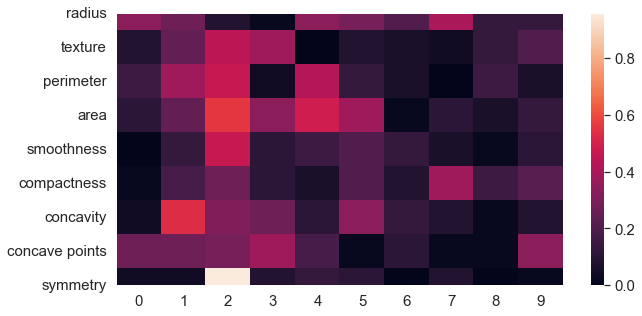

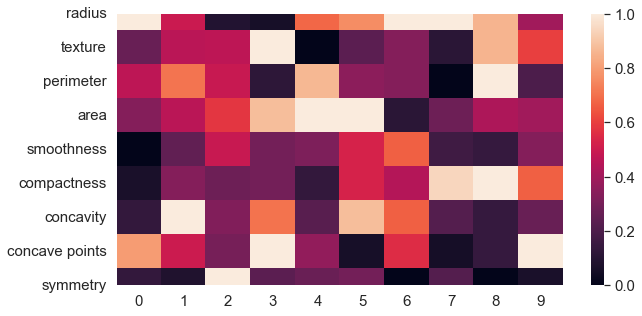

In [9]:
plt.figure(figsize=[10, 5])
sns.heatmap(distances.loc[outlier_idx].T)
plt.show()
plt.figure(figsize=[10, 5])
distances_norm = distances.loc[outlier_idx].T / np.max(distances.loc[outlier_idx].T.values, axis=0)
sns.heatmap(distances_norm.T.head(50).T)

<BarContainer object of 9 artists>

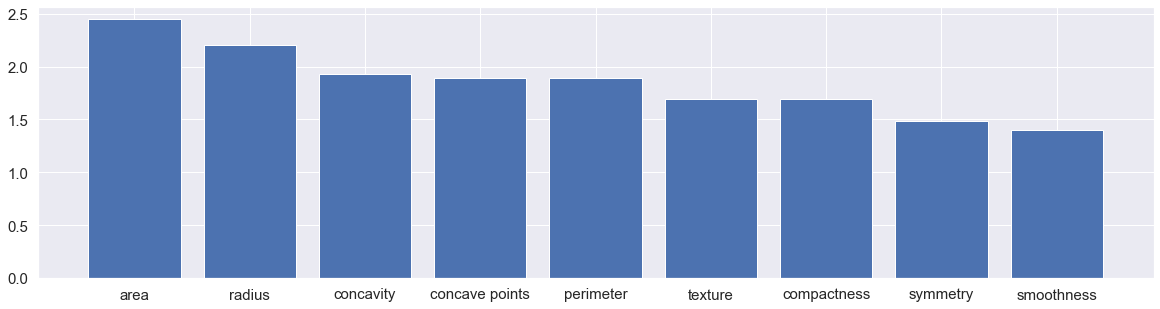

In [20]:
TOP_COLUMNS = 12
plt.figure(figsize=[20, 5])
dist_sum = distances.loc[outlier_idx].sum().sort_values(ascending=False)[:TOP_COLUMNS]
plt.bar(dist_sum.index, dist_sum.values)

In [19]:
dist_sum.index[:]

Index(['area', 'radius', 'concavity'], dtype='object')

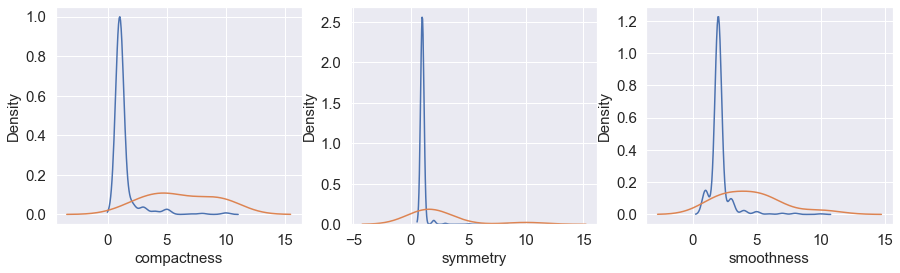

In [21]:
# plot the density estimation for the top 3 feautres for the inlier and outlier class
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, c in zip(axes, dist_sum.index[-3:].values):
    sns.kdeplot(data=df[df["label"] == 	b"'no'"], x=c, ax=ax)
    sns.kdeplot(data=df[df["label"] == 	b"'yes'"], x=c, ax=ax)

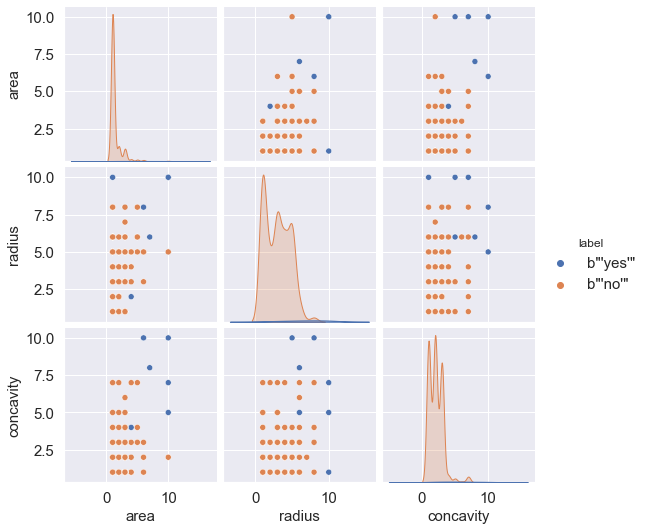

In [12]:
# plot the density estimation for the top 3 feautres for the inlier and outlier class

sns.pairplot(df, hue="label", vars=dist_sum.index[:3].values)

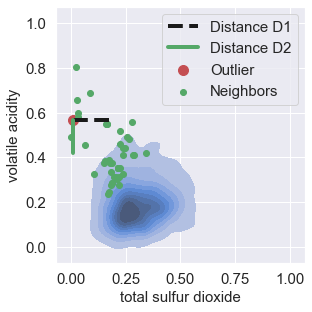

In [44]:
# analyse single outlier

IDX = 4827

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

col_1 = "total sulfur dioxide"
col_2 = "volatile acidity"

columns = df.columns[1:]
col_1_idx = np.argsort(columns == col_1)[-1]
col_2_idx = np.argsort(columns == col_2)[-1]

temp = pd.DataFrame(X_scaled, columns=columns, index=df.index)
sns.kdeplot(data=temp, x=col_1, y=col_2, ax=ax, fill=True)
ax.scatter(X_scaled[IDX][col_1_idx], X_scaled[IDX][col_2_idx], c="r", s=100, label="Outlier")
o_neigh = neigh[IDX][1:]
point = X_scaled[IDX][[col_1_idx, col_2_idx]]
dist = distances.loc[IDX][[col_1, col_2]].values 
ax.plot([point[0],point[0]+dist[0]], [point[1],point[1]], c="k", lw=4, linestyle="dashed", label="Distance D1")
ax.plot([point[0],point[0]], [point[1],point[1]-dist[1]], c="g", lw=4, label="Distance D2")
ax.scatter(X_scaled[o_neigh, col_1_idx],X_scaled[o_neigh, col_2_idx], c="g", label="Neighbors")
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.legend(loc="upper right")
fig.tight_layout()
plt.savefig(f"images/knn_outlier_analyis_{IDX}.svg", bbox_inches="tight")
plt.show()